![](pics/header.png)

# Creating Point Clouds from Disparity

Kevin J. Walchko, Phd

20 Nov 2018

Stereo Vision is utilizing 2 (or more) pinhole cameras. We typically use a similar model to explaine geometry, but since we have more than one camera, we can get depth (z-direction) information.

## References

- morethantechnical: [Simple triangulation with OpenCV from Harley & Zisserman [w/ code]](https://www.morethantechnical.com/2012/01/04/simple-triangulation-with-opencv-from-harley-zisserman-w-code/)
- morethantechnical: [Structure-from-Motion Toy Lib Upgrades to OpenCV 3](https://www.morethantechnical.com/2016/10/17/structure-from-motion-toy-lib-upgrades-to-opencv-3/)
- morethantechnical: [Structure from Motion and 3D reconstruction on the easy in OpenCV 2.3+ [w/ code]](https://www.morethantechnical.com/2012/02/07/structure-from-motion-and-3d-reconstruction-on-the-easy-in-opencv-2-3-w-code/)

## Reprojecting to Disparity to 3D Point Cloud

Disparities maps (x-x') can be reprojected to 3d:

\begin{eqnarray}
    Z = \frac{fT_x}{x-x'}
\end{eqnarray}

During stereo calibration (`cv2.stereoCalibrate()`), there is a Q matrix which is produced. This can also reproject image points to world points using the `cv2.reprojectImageTo3d()`:

\begin{eqnarray}
    \begin{bmatrix}
        X & Y & Z & W
    \end{bmatrix}^T = Q \begin{bmatrix} x & y & d & 1 \end{bmatrix}^T \\
    Q = \begin{bmatrix}
        1 & 0 & 0 & -c_x \\
        0 & 1 & 0 & -c_y \\
        0 & 0 & 0 & f \\
        0 & 0 & -1/T_x & (c_x - c_x')/T_x
    \end{bmatrix}
\end{eqnarray}

Now the true 3D points are X/W, Y/W, and Z/W. If `CV_CALIB_ZERO_DISPARITY` is set, then $c_x = c_x'$ and the value in the lower right corner of Q is 0. Doing a little bit of algebra on the equations above leads you to:

\begin{eqnarray}
     Q \begin{bmatrix} x & y & d & 1 \end{bmatrix}^T = 
     \begin{bmatrix}
         \frac{-Tx (x - c_x)}{d} \\
         \frac{-Tx (y - c_y)}{d} \\
         \frac{-f T_x}{d}
     \end{bmatrix} = \begin{bmatrix} X & Y & Z \end{bmatrix}^T
\end{eqnarray}

If you look at the first equation for depth (Z) above and compare it to the last, they are the same. From a units stand point, for X, Y and Z and assuming the translation ($T_x$) units were meters (m), you end up with $\frac{m*px}{px} \Rightarrow m$. Thus your units have to be:

| Parameter               | Units  |
|-------------------------|--------|
| Baseline ($T_x$)        | meters |
| Focal length ($f$)      | pixels | 
| Principle point ($c_x$) | pixels |
| Disparity (d)           | pixels |

You can produce the 3D points using:

- `cv2.perspectiveTransform()`: this transforms an array of points to 3D space
- `cv2.reprojectImageTo3D()`: this transforms a whole disparity image

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

import cv2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10) # set default figure width

from slurm import storage
from pprint import pprint
from pathlib import Path

In [3]:
import opencv_camera as oc
from opencv_camera import CameraCalibration
from opencv_camera.stereo_calibrate import StereoCalibration
from opencv_camera.targets.chessboard import ChessboardFinder
from opencv_camera import UnDistort
from opencv_camera.color_space import bgr2gray, gray2bgr
from opencv_camera.display.epipolar import drawEpipolarLines
from opencv_camera.display.stereo import coverage, tip_sheet
from opencv_camera.display.stereo import stereoOverlay

In [4]:
# See the answer from OpenCV Tutorials
# this is the answer they came up with
ans = cv2.FileStorage("cal_pics/intrinsics.yml", cv2.FILE_STORAGE_READ)
print("Left camera K1 and D1")
print("-"*40)
print(ans.getNode("M1").mat())
print(ans.getNode("D1").mat())
print("")
print("Right camera K2 and D2")
print("-"*40)
print(ans.getNode("M2").mat())
print(ans.getNode("D2").mat())

Left camera K1 and D1
----------------------------------------
[[534.803   0.    335.686]
 [  0.    534.803 240.662]
 [  0.      0.      1.   ]]
[[ 0.296 -1.035  0.     0.     0.   ]]

Right camera K2 and D2
----------------------------------------
[[534.803   0.    334.557]
 [  0.    534.803 242.053]
 [  0.      0.      1.   ]]
[[-0.169 -0.112  0.     0.     0.   ]]


In [5]:
def readImages(pattern):
    p = Path("cal_pics").glob(pattern)
    p = list(p)
    p.sort()
    return [cv2.imread(str(f),0) for f in p]

imgL = readImages("left*.jpg")
imgR = readImages("right*.jpg")

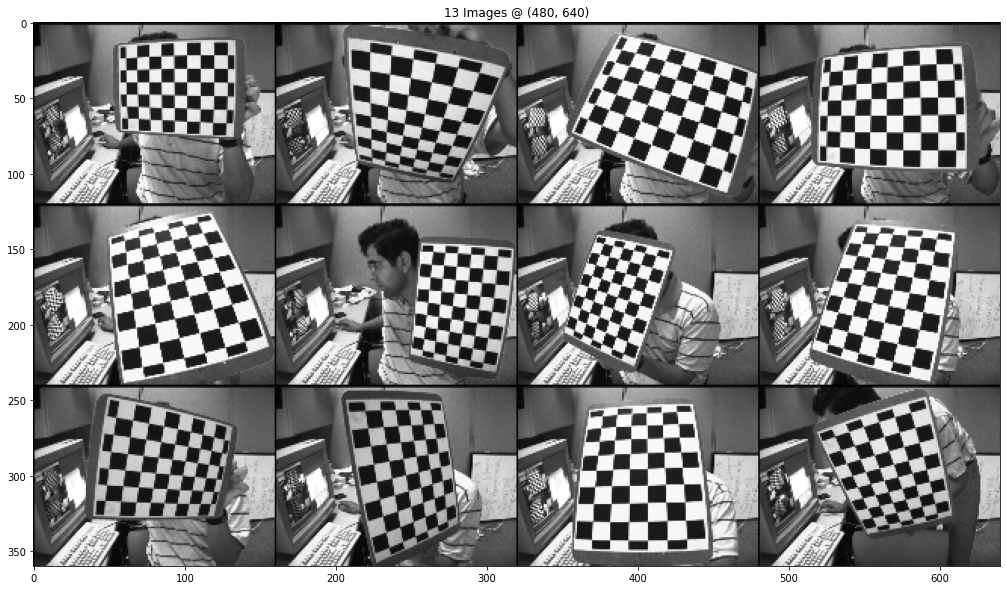

In [6]:
# a simple mosasic of the various images
plt.imshow(tip_sheet(imgL, width=4), cmap="gray")
plt.title(f"{len(imgL)} Images @ {imgL[0].shape}");

In [11]:
ud1 = UnDistort(sc.K1, sc.d1, 640, 480)
ud2 = UnDistort(sc.K2, sc.d2, 640, 480, sc.R)

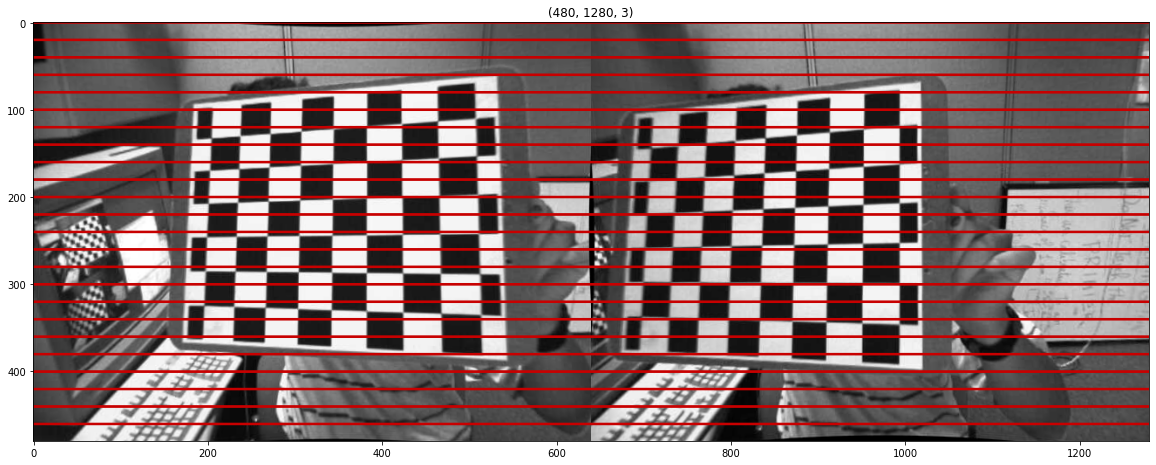

In [12]:
num = 3
cl = ud1.undistort(imgL[num])
cr = ud2.undistort(imgR[num])
# corr = np.hstack((cl, cr))
corr = drawEpipolarLines(cl,cr, thickness=2)
plt.imshow(corr, cmap="gray")
plt.title(f"{corr.shape}");

# Stereo Matching

So ideally you want a lot of unique features to match and produce a good disparity. However, a calibration target has a lot of similar (chessboard corners) that are the same. Although this is great for calibration, it isn't great for calculating disparity.

In [17]:
# let's do some stereo matching!
if True:
    window_size = 3
    mindisp = 16*3
    maxdisp = 16*8
    numdisp = maxdisp-mindisp
    stereo = cv2.StereoSGBM_create(
        minDisparity = mindisp,
        numDisparities = numdisp, # Maximum disparity minus minimum disparity
        blockSize = 16,
        P1 = 8*1*window_size**2,  # parameters for disparity matching
        P2 = 32*1*window_size**2,
        disp12MaxDiff = 1,  # matching differences
        uniquenessRatio = 10,  # matching parameter
        speckleWindowSize = 100,  # filtering to remove speckles in an image
        speckleRange = 2
    )
elif False:
    stereo = cv2.StereoBM_create(
        numDisparities=16*16,
        blockSize=15)
else:
    maxdisp = 16*9
    mindisp = 16*3
    numdisp = maxdisp - mindisp
    blksize = 11
    window_size = 3*3
    stereo = cv2.StereoSGBM_create(numDisparities=numdisp, blockSize=blksize,
       P1 = 8*1*window_size**2,  # parameters for disparity matching
       P2 = 32*1*window_size**2,
       mode=1
    )

# calculate disparity between image features in the left/right images
disparity = stereo.compute(ll,rr)

# compute returns an int16 that has crazy values, if we 
# convert this into a float, it makes more sense.
# This puts it into a range minDistarity to maxDisparity
disparity = disparity.astype(np.float32)/16

# do some filtering ... disparities of 0 will product infinite
# results when reporjecting them to a 3D point cloud becuase
# the disparity is in the denominator.
mask = disparity < 1
disparity[mask] = 1

mask = disparity > numdisp
disparity[mask] = numdisp

# could also do:
# disparity = cv2.normalize(disparity, alpha=mindisp, beta=numdisp) ???

Text(0.5, 1.0, 'SGBM Disparity Map, image size: (480, 640), type: float32')

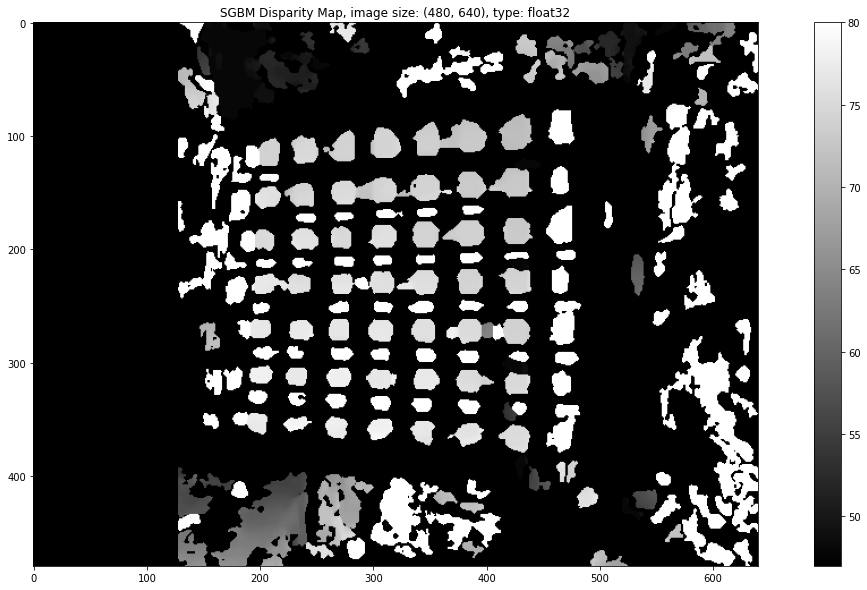

In [18]:
# let's plot our disparity map
plt.figure(figsize=(20,10))
plt.imshow(disparity, cmap='gray')
plt.colorbar();
plt.title(f'SGBM Disparity Map, image size: {disparity.shape}, type: {disparity.dtype}')

Notice how the disparity map above shows black segment. These are locations in 3D space that the left camera can see, but the right camera cannot see. This is typical of all stereo systems. If you have the time (or computation power), you can do better than this!

# Pretty Disparity Map [broke]

Like above, you see depth maps with holes in them due to the camera setup. Generally, depth maps are only calculated using the left camera as the origin. [Here](http://timosam.com/python_opencv_depthimage) we are following a python version of the OpenCV tutorials and creating another depth map based on the right camera. Then we filter and combine the two so holes are filled.

In [225]:
def prettyDisparity(imgL, imgR, stereo, **kwargs):
    """Creates a right stereo matcher based off the left stereo 
    matcher and then calculates a combined disparity map from
    both aspect in order to close up any wholes."""
    right_matcher = cv2.ximgproc.createRightMatcher(stereo)
     # FILTER Parameters
    lmbda = kwargs.get('lamda',80000)
    sigma = kwargs.get('signam',1.2)
    visual_multiplier = kwargs.get('mult',1.0)

    wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)

    displ = stereo.compute(imgL, imgR)  # .astype(np.float32)/16
    dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
    displ = np.int16(displ)
    dispr = np.int16(dispr)
    filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!

    # need to normalize the image, so its values are between 0-255
    filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
    # need to convert back to 8b integer values
    filteredImg = np.uint8(filteredImg)
    return filteredImg

In [226]:
# this takes a lot more time, but makes a pretty picture
params = {
    'lamda': 10000,
    'signam': 1.2,
    'mult': 1.0
}
filteredImg = prettyDisparity(ll, rr, stereo, **params)
plt.imshow(filteredImg, cmap='hot')
plt.title('{}'.format(params));

AttributeError: module 'cv2.cv2' has no attribute 'ximgproc'

# Recovering the Point Cloud [not working yet]

Now that we know the camera parameters and have a disparity map, we should be able to reproject this 2D disparity map back into 3D space.

**this doesn't work correctly right now**

In [37]:
# disp = stereo.compute(imgL, imgR).astype(np.float32)/16
# mask = disp < 0
# disp[mask] = 0

# plt.figure()
# plt.imshow(disp)
# plt.colorbar()

# print('disp min/max:', disp.min(), disp.max())
# print('disp:', disp.shape)

# points = cv2.reprojectImageTo3D(disp, rc.Q, handleMissingValues=True)
# # colors = cv2.cvtColor(imgL, cv2.COLOR_GRAY2RGB)
# colors = imgL
# print('imgL', imgL.shape)

# print('[ Points {}]---------------------'.format(points.shape))
# print(' x min/max:', points[:,:,0].min(), points[:,:,0].max())
# print(' y min/max:', points[:,:,1].min(), points[:,:,1].max())
# print(' z min/max:', points[:,:,2].min(), points[:,:,2].max())
      

# print('colors:', colors.shape)

# print('-'*50)

# # mask = disp < 4
# # out_points = points[mask]
# # out_colors = colors[mask]
# # points[mask] = 200 # disp.max()


# # colors[mask]
# out_points = points
# o = points


# # mask = out_points < 1000
# # o = out_points[mask]
# # oc = out_colors[mask]


# print('filtered points min/max:', out_points.min(), out_points.max())
# print("filtered points:", out_points.shape)

# # o = out_points
# # # print(o[:,0])
# # fig = plt.figure(figsize=(20,10))
# # # ax = fig.gca(projection='3d')
# # # ax.plot_surface(o[:,0],o[:,1],o[:,2])
# # ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(o[:,0],o[:,1],o[:,2])
# # # plt.show()

In [29]:
def getDistanceMap(img, disp, Q, sat=1000):
    # shouldn't be negative disparities, weed them out
    mask = disp < 2
    disp[mask] = 2
    
    points = cv2.reprojectImageTo3D(disp, Q, handleMissingValues=True)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # color = img.copy()  # since this only returns depth, color is useless
    
    # remove any really big distances
    z = points[:,:,2]
    z[z > sat] = sat
    
    # need to normalize the image, so its values are between 0-255
    z = cv2.normalize(z, None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    # need to convert back to 8b integer values
    z = np.uint8(z)
    return z

def getDistanceMap2(img, disp, Q, sat=1000):
    # shouldn't be negative disparities, weed them out
    mask = disp < 2
    disp[mask] = 2
    
    points = cv2.reprojectImageTo3D(disp, Q, handleMissingValues=True)
    if len(img.shape) < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    color = img.copy()  # since this only returns depth, color is useless
    
    # remove any really big distances
    x = points[:,:,0]
    x[x > sat] = sat
    
    y = points[:,:,1]
    y[y > sat] = sat
    
    z = points[:,:,2]
    z[z > sat] = sat
    
    # need to normalize the image, so its values are between 0-255
#     z = cv2.normalize(z, None, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
    # need to convert back to 8b integer values
#     z = np.uint8(z)
    return points, color